In [5]:
from pathlib import Path
import json
import geopandas as gpd
import pandas as pd
import netCDF4
import matplotlib.pyplot as plt

In [6]:
basePath = Path.cwd().parent.parent.parent / 'inputs'
shpFilePath = basePath / 'global_osm_rails'
osmRailDf = gpd.read_file(shpFilePath / 'global_osm_rails.shp')

In [8]:
import xarray as xr

diffNcPath = basePath / 'spear_tas_diff.nc'


tasDiffNc = netCDF4.Dataset(diffNcPath)
tasDiffdf = xr.open_dataset(diffNcPath).to_dataframe()
# tasDiffdf.index.names =['geo_center_x_zone', 'geo_center_y_zone']
tasDiffdf = tasDiffdf.reset_index()
tasDiffdf.loc[tasDiffdf.lon > 180, 'lon'] = tasDiffdf.lon -360
tasDiffdf = gpd.GeoDataFrame(
  tasDiffdf, geometry=gpd.points_from_xy(tasDiffdf.lon, tasDiffdf.lat), crs="epsg:4326"
)

In [9]:
osmRailDf['geo_center'] = osmRailDf.centroid

/tmp/ipykernel_697435/2563424661.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  osmRailDf['geo_center'] = osmRailDf.centroid


In [10]:
gbRail = osmRailDf.cx[-1.57216793459:1.68153079591,48.959999905:56]
tasDiffdf

,lon,lat,tas,geometry
0,0.3125,-89.75,5.272278,POINT (0.3125 -89.75)
1,0.3125,-89.25,5.213562,POINT (0.3125 -89.25)
2,0.3125,-88.75,5.120956,POINT (0.3125 -88.75)
3,0.3125,-88.25,5.132568,POINT (0.3125 -88.25)
4,0.3125,-87.75,5.142838,POINT (0.3125 -87.75)
...,...,...,...,...
207355,-0.3125,87.75,11.970917,POINT (-0.3125 87.75)
207356,-0.3125,88.25,11.975571,POINT (-0.3125 88.25)
207357,-0.3125,88.75,11.973984,POINT (-0.3125 88.75)
207358,-0.3125,89.25,11.972626,POINT (-0.3125 89.25)


In [11]:
import numpy as np
from shapely import ops
joined = gpd.sjoin_nearest(osmRailDf.to_crs(epsg=3857), tasDiffdf.to_crs(epsg=3857)).to_crs(epsg=4326)

non_line_strings = joined.geom_type != 'LineString'
joined.loc[non_line_strings, 'geometry'] = joined.loc[non_line_strings, 'geometry'].apply(ops.linemerge)
joined.loc[joined.geom_type != 'LineString', 'geometry'] = joined.loc[joined.geom_type != 'LineString', 'geometry'].apply(lambda g : g.geoms[0])

joined['line_segs']=[c for c in map(
  lambda g: list((g.coords[0],g.coords[-1])),
  [g for g in joined.geometry]
)]
joined['tas'] = joined['tas'] * 2/3

In [12]:
from shapely import LineString

simplified = gpd.GeoDataFrame(
  geometry=joined['line_segs'].apply(lambda segs : LineString(segs))
)
simplified['tas'] = joined['tas']

In [14]:
worldmap = gpd.read_file(basePath / 'naturalearth_lowres/ne_10m_admin_0_countries.shp')

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,TLC,ADMIN,...,FCLASS_TR,FCLASS_ID,FCLASS_PL,FCLASS_GR,FCLASS_IT,FCLASS_NL,FCLASS_SE,FCLASS_BD,FCLASS_UA,geometry
78,Admin-0 country,0,2,United Kingdom,GB1,1,2,Country,1,United Kingdom,...,None,None,None,None,None,None,None,None,None,"MULTIPOLYGON (((-7.2471 55.06932, -7.25674 55...."


111927

<Axes: title={'center': 'Rail Temperature Projections for South Asia'}>

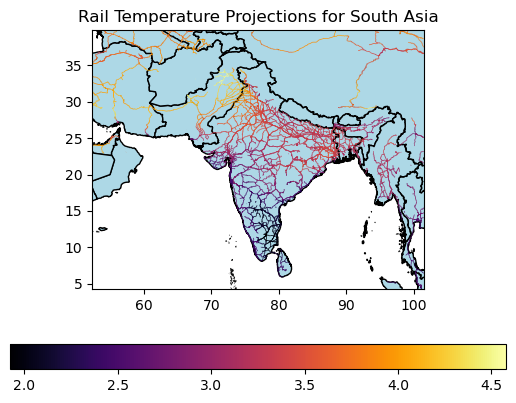

In [ ]:
# for country in ['USA', 'UK', 'Europe', 'Russia / China', 'South Asia (Pakistan, India) / SE Asia']
base = worldmap.plot(color='lightblue', edgecolor='black')
nation = worldmap[worldmap.ADMIN == 'United Kingdom']
nation_name = nation.ADMIN.to_string(index=False)
nation_bounds = nation.total_bounds
display(nation)

# Contiguous USA
# nation_bounds = (-124.7844079, 24.7433195, -66.9513812, 49.3457868,)
# nation_name = ''
# Europe
# nation_bounds = (-22.351567,33.162177,39.789058,68.915600)
# nation_name = 'Europe'
# China / Russia
# nation_bounds = (25.101555,19.181933,187.882755,78.172407)
# nation_name = 'China / Russia'
# South Asia
nation_bounds = (53.357426,5.268747,100.468755,38.816910)
nation_name = 'South Asia'
# SE Asia
nation_bounds = (91.177731,-13.614711,142.417966,28.804665)
nation_name = 'South East Asia'


pad = 1  # add a padding around the geometry
nation_bounds = (
  nation_bounds[0] - pad,
  nation_bounds[1] - pad,
  nation_bounds[2] + pad,
  nation_bounds[3] + pad
)
xmin, ymin, xmax, ymax = nation_bounds
base.set_xlim(xmin, xmax)
base.set_ylim(ymin, ymax)

# toPlot = tasDiffdf.clip(nation_bounds)
# display(toPlot)
# toPlot.plot(ax=base, column='tas', cmap='inferno', legend=True, linewidth=0.5, alpha=.5)
toPlot = joined.clip(nation_bounds)[['tas', 'geometry']]
display(len(toPlot))
toPlot.plot(ax=base, column='tas', cmap='inferno', legend=True, legend_kwds={'orientation':'horizontal'}, linewidth=0.5)
plt.title(f'Rail Temperature Projections for {nation_name}')
display(base)

<Axes: >

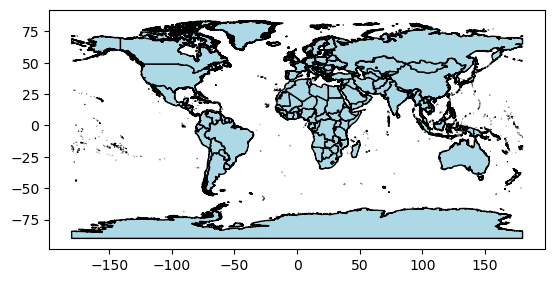

In [ ]:
worldmap.plot(color='lightblue', edgecolor='black')